In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import clip
from models import TransformerClassifier, custom_loss_1, custom_loss_2
import pandas as pd
import os

In [2]:
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = 'biggan_full'
os.makedirs(f'./weights/{dataset}', exist_ok=True)
os.makedirs(f'./results/{dataset}', exist_ok=True)

In [4]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model.float()

student_model = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=4, dropout=0.2, batch_first=True), num_layers=1).to(device)

teacher_model = TransformerClassifier().to(device).eval()
teacher_model.load_state_dict(torch.load(f"./weights/{dataset}/teacher.pth", weights_only=True))
teacher_model = create_feature_extractor(teacher_model, return_nodes={"transformer_encoder": "layer1"})

augmentor = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=4, dropout=0.2, batch_first=True), num_layers=1).to(device)

In [5]:
train_path = f'./data/{dataset}/train'

train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

ai_idx = [i for i in range(len(train_folder)) if train_folder.imgs[i][1] != train_folder.class_to_idx['ai']]
nature_idx = [i for i in range(len(train_folder)) if train_folder.imgs[i][1] == train_folder.class_to_idx['nature']]

ai_train_folder = Subset(train_folder, ai_idx)
nature_train_folder = Subset(train_folder, nature_idx)

ai_train_folder, ai_val_folder = random_split(ai_train_folder, [0.8, 0.2])
nature_train_folder, nature_val_folder = random_split(nature_train_folder, [0.8, 0.2])


ai_train_loader = DataLoader(ai_train_folder, batch_size=64, shuffle=True)
ai_val_loader = DataLoader(ai_val_folder, batch_size=64, shuffle=False)

nature_train_loader = DataLoader(nature_train_folder, batch_size=64, shuffle=True)
nature_val_loader = DataLoader(nature_val_folder, batch_size=64, shuffle=False)

In [6]:
# _datasets = ['adm', 'biggan', 'glide', 'midjourney', 'sdv5', 'vqdm', 'wukong']

# ai_train_folders = []
# ai_val_folders = []
# nature_train_folders = []
# nature_val_folders = []

# for ds in _datasets:
# 	train_path = f'./data/{ds}/train'
 
# 	train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

# 	ai_idx = [i for i in range(len(train_folder)) if train_folder.imgs[i][1] != train_folder.class_to_idx['ai']]
# 	nature_idx = [i for i in range(len(train_folder)) if train_folder.imgs[i][1] == train_folder.class_to_idx['nature']]

# 	ai_train_folder = Subset(train_folder, ai_idx)
# 	nature_train_folder = Subset(train_folder, nature_idx)
# 	ai_train_folder, ai_val_folder = random_split(ai_train_folder, [0.8, 0.2])
# 	nature_train_folder, nature_val_folder = random_split(nature_train_folder, [0.8, 0.2])
 
# 	ai_train_folders.append(ai_train_folder)
# 	ai_val_folders.append(ai_val_folder)
# 	nature_train_folders.append(nature_train_folder)
# 	nature_val_folders.append(nature_val_folder)
 
# ai_train_folder = ConcatDataset(ai_train_folders)
# ai_val_folder = ConcatDataset(ai_val_folders)
# nature_train_folder = ConcatDataset(nature_train_folders)
# nature_val_folder = ConcatDataset(nature_val_folders)

# ai_train_loader = DataLoader(ai_train_folder, batch_size=16, shuffle=True)
# ai_val_loader = DataLoader(ai_val_folder, batch_size=16, shuffle=False)
# nature_train_loader = DataLoader(nature_train_folder, batch_size=16, shuffle=True)
# nature_val_loader = DataLoader(nature_val_folder, batch_size=16, shuffle=False)

In [7]:
# def _convert_image_to_rgb(image):
#     return image.convert("RGB")

# def _transform(n_px = 224, flip_mode = None):
#     flip = {
#         None: [],
# 		1: [transforms.RandomHorizontalFlip(p=1)],
# 		2: [transforms.RandomVerticalFlip(p=1)],
# 		3: [transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1)]
# 	}
#     return transforms.Compose([
#         transforms.Resize(n_px, interpolation=transforms.InterpolationMode.BICUBIC),
#         transforms.CenterCrop(n_px),
#         *flip[flip_mode],
#         _convert_image_to_rgb,
#         transforms.ToTensor(),
#         transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
#     ])

In [8]:
# train_path = f'./data/{dataset}/train'

# ai_train_folders = []
# nature_train_folders = []

# for k in [None, 1, 2, 3]:
#     train_folder = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=k))
#     ai_idx = [i for i in range(len(train_folder)) if train_folder.imgs[i][1] != train_folder.class_to_idx['ai']]
#     nature_idx = [i for i in range(len(train_folder)) if train_folder.imgs[i][1] == train_folder.class_to_idx['nature']]
    
#     ai_train_folder = Subset(train_folder, ai_idx)
#     nature_train_folder = Subset(train_folder, nature_idx)
#     ai_train_folders.append(ai_train_folder)
#     nature_train_folders.append(nature_train_folder)

# ai_train_folder = ConcatDataset(ai_train_folders)
# nature_train_folder = ConcatDataset(nature_train_folders)

# ai_train_folder, ai_val_folder = random_split(ai_train_folder, [0.8, 0.2])
# nature_train_folder, nature_val_folder = random_split(nature_train_folder, [0.8, 0.2])


# ai_train_loader = DataLoader(ai_train_folder, batch_size=64, shuffle=True)
# ai_val_loader = DataLoader(ai_val_folder, batch_size=64, shuffle=False)

# nature_train_loader = DataLoader(nature_train_folder, batch_size=64, shuffle=True)
# nature_val_loader = DataLoader(nature_val_folder, batch_size=64, shuffle=False)

In [9]:
epochs = 5

nature_student_optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
ai_student_optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
augmentor_optimizer = torch.optim.AdamW(augmentor.parameters(), lr=1e-5)

loss_fn_1 = nn.MSELoss()
loss_fn_2 = custom_loss_2(M=4)

result = []

In [10]:
min_val_loss = float('inf')

for epoch in range(epochs):
	
	# stage 1
	with tqdm(total=len(nature_train_loader), desc=f'Stage 1 Train Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
		student_model.train()
		sum_train_loss1 = 0
		for batch, (images, _) in enumerate(nature_train_loader):
			images = images.to(device)
			with torch.no_grad():
				image_features = clip_model.encode_image(images)
				teacher_output = teacher_model(image_features)['layer1']
			student_output = student_model(image_features)
			loss = loss_fn_1(student_output, teacher_output)
			sum_train_loss1 += loss.item()
			nature_student_optimizer.zero_grad()
			loss.backward()
			nature_student_optimizer.step()
			pbar.set_postfix({'loss': sum_train_loss1/(batch+1)})
			pbar.update()
			
	with tqdm(total=len(nature_val_loader), desc=f'Stage 1 Val Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
		student_model.eval()
		with torch.inference_mode():
			sum_eval_loss1 = 0
			for batch, (images, _) in enumerate(nature_val_loader):
				images = images.to(device)
				image_features = clip_model.encode_image(images)
				teacher_output = teacher_model(image_features)['layer1']
				student_output = student_model(image_features)
				sum_eval_loss1 += loss_fn_1(student_output, teacher_output).item()
				pbar.set_postfix({'loss': sum_eval_loss1/(batch+1)})
				pbar.update()
				
	# stage 2
	augmentor.eval()
	with tqdm(total=len(ai_train_loader), desc=f'Stage 2 Train Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
		student_model.train()
		sum_train_loss2 = 0
		for batch, (images, _) in enumerate(ai_train_loader):
			images = images.to(device)
			with torch.no_grad():
				image_features = clip_model.encode_image(images)
				image_features = augmentor(image_features)
				teacher_output = teacher_model(image_features)['layer1']
			student_output = student_model(image_features)
			loss = loss_fn_2(student_output, teacher_output)
			sum_train_loss2 += loss.item()
			ai_student_optimizer.zero_grad()
			loss.backward()
			ai_student_optimizer.step()
			pbar.set_postfix({'loss': sum_train_loss2/(batch+1)})
			pbar.update()
	
	with tqdm(total=len(ai_val_loader), desc=f'Stage 2 Val Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
		student_model.eval()
		with torch.inference_mode():
			sum_eval_loss2 = 0
			for batch, (images, _) in enumerate(ai_val_loader):
				images = images.to(device)
				image_features = clip_model.encode_image(images)
				image_features = augmentor(image_features)
				teacher_output = teacher_model(image_features)['layer1']
				student_output = student_model(image_features)
				sum_eval_loss2 += loss_fn_2(student_output, teacher_output).item()
				pbar.set_postfix({'loss': sum_eval_loss2/(batch+1)})
				pbar.update()
				
	# stage 3
	student_model.eval()
	with tqdm(total=len(ai_train_loader), desc=f'Stage 3 Train Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
		augmentor.train()
		sum_train_loss3 = 0
		for batch, (images, _) in enumerate(ai_train_loader):
			images = images.to(device)
			with torch.no_grad():
				image_features = clip_model.encode_image(images)
			image_features = augmentor(image_features)
			teacher_output = teacher_model(image_features)['layer1']
			student_output = student_model(image_features)
			loss = loss_fn_1(student_output, teacher_output)
			sum_train_loss3 += loss.item()
			augmentor_optimizer.zero_grad()
			loss.backward()
			augmentor_optimizer.step()
			pbar.set_postfix({'loss': sum_train_loss3/(batch+1)})
			pbar.update()
	
	with tqdm(total=len(ai_val_loader), desc=f'Stage 3 Val Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
		augmentor.eval()
		with torch.inference_mode():
			sum_eval_loss3 = 0
			for batch, (images, _) in enumerate(ai_val_loader):
				images = images.to(device)
				image_features = clip_model.encode_image(images)
				teacher_output = teacher_model(image_features)['layer1']
				student_output = student_model(image_features)
				sum_eval_loss3 += loss_fn_1(student_output, teacher_output).item()
				pbar.set_postfix({'loss': sum_eval_loss3/(batch+1)})
				pbar.update()
										  
	result.append({'epoch': epoch+1, 'stage1_train_loss': sum_train_loss1/len(nature_train_loader), 'stage1_val_loss': sum_eval_loss1/len(nature_val_loader), 'stage2_train_loss': sum_train_loss2/len(ai_train_loader), 'stage2_val_loss': sum_eval_loss2/len(ai_val_loader), 'stage3_train_loss': sum_train_loss3/len(ai_train_loader), 'stage3_val_loss': sum_eval_loss3/len(ai_val_loader)})
	result_df = pd.DataFrame(result)
	result_df.to_csv(f'./results/{dataset}/student.csv', index=False)
 
	torch.save(student_model.state_dict(), f"./weights/{dataset}/student.pth")

Stage 1 Train Epoch 1/5:   0%|          | 0/2025 [00:00<?, ?batch/s]

c:\Users\hoang\xldl\.venv\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Stage 3 Val Epoch 5/5: 100%|██████████| 507/507 [04:51<00:00,  1.74batch/s, loss=1.62]


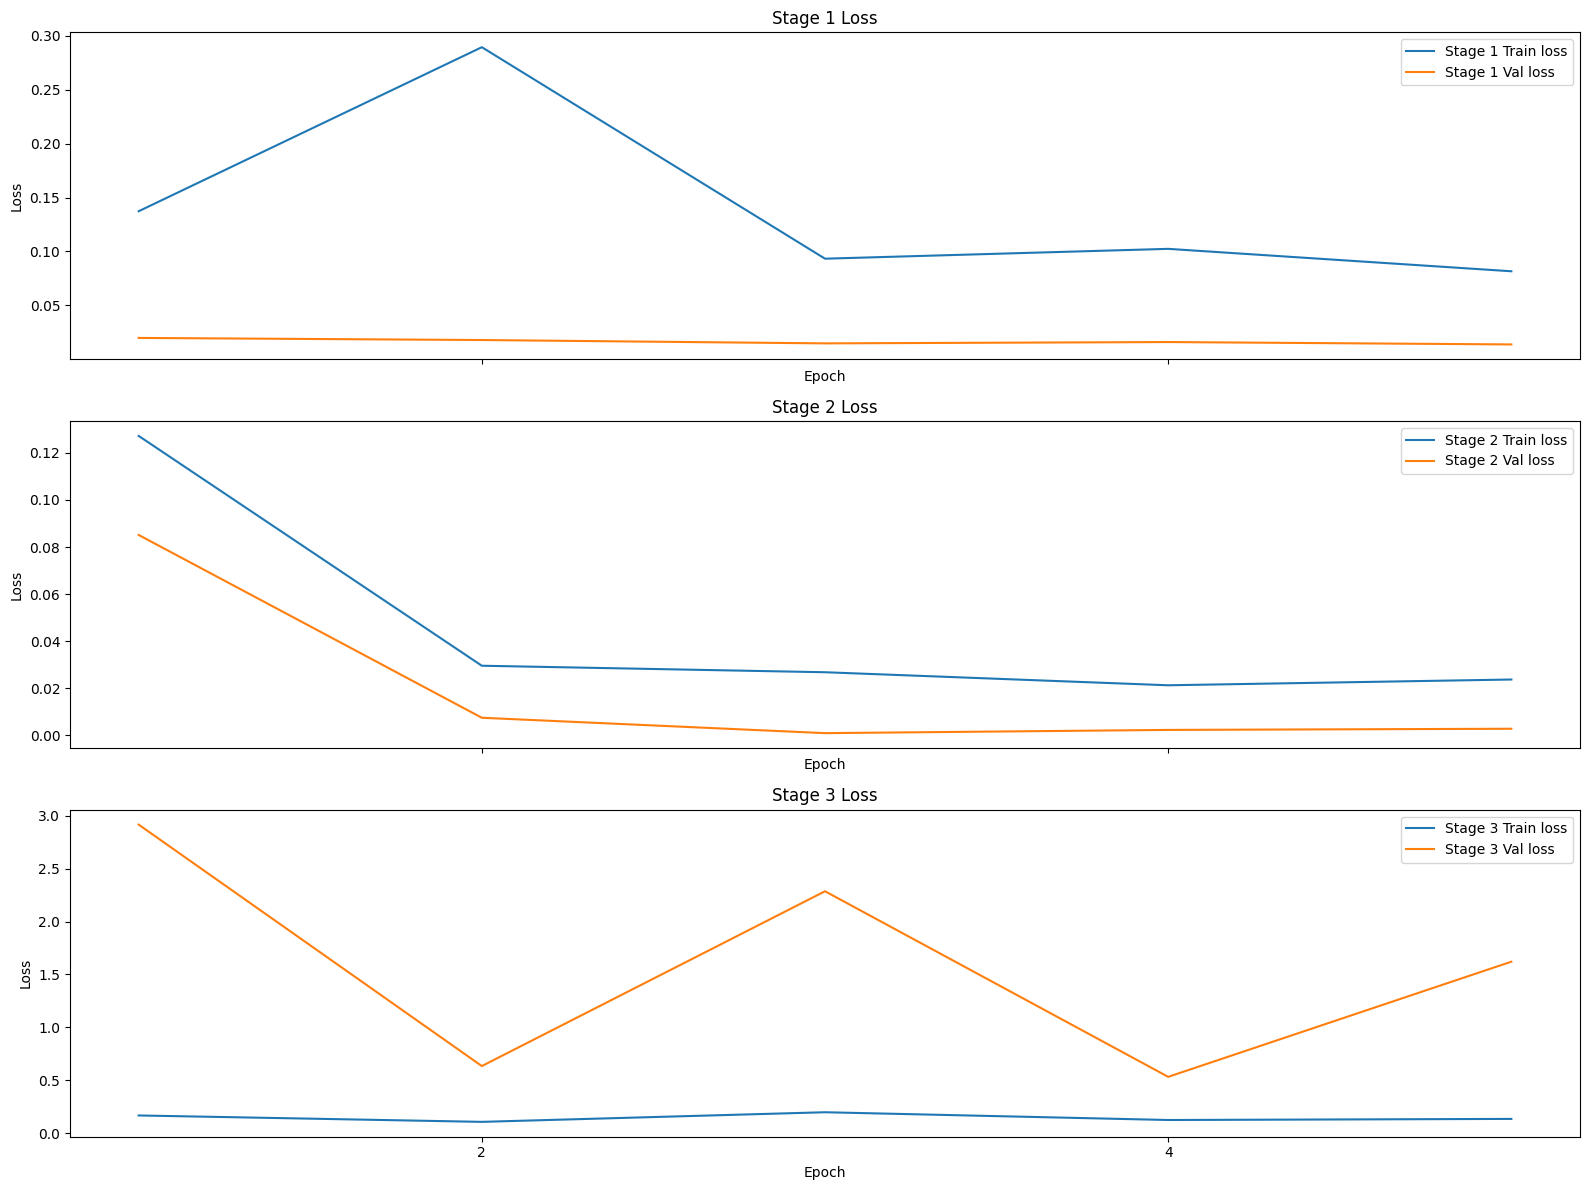

In [11]:
import matplotlib.pyplot as plt

result = pd.read_csv(f'./results/{dataset}/student.csv')

fig, ax = plt.subplots(3, 1, figsize=(16, 12), sharex='col')

ax[0].plot(result['epoch'], result['stage1_train_loss'], label='Stage 1 Train loss')
ax[0].plot(result['epoch'], result['stage1_val_loss'], label='Stage 1 Val loss')
ax[0].set_title('Stage 1 Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_xticks(result['epoch'][1::2])
ax[0].legend()

ax[1].plot(result['epoch'], result['stage2_train_loss'], label='Stage 2 Train loss')
ax[1].plot(result['epoch'], result['stage2_val_loss'], label='Stage 2 Val loss')
ax[1].set_title('Stage 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(result['epoch'][1::2])
ax[1].legend()

ax[2].plot(result['epoch'], result['stage3_train_loss'], label='Stage 3 Train loss')
ax[2].plot(result['epoch'], result['stage3_val_loss'], label='Stage 3 Val loss')
ax[2].set_title('Stage 3 Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_xticks(result['epoch'][1::2])
ax[2].legend()

fig.tight_layout()